In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import joblib

In [19]:
df = pd.read_csv("I:/DataSet/archive/DeepLearWing.csv")

In [20]:
# Drop rows with missing values
df = df[['angle', 'reynolds', 'x_coords', 'y_coords', 'cl']].dropna()

In [21]:
# --- Parse coordinate strings ---
# Define the max number of coordinates to use
MAX_COORDS = 50

def parse_and_fix_coords(s, max_len=MAX_COORDS):
    vals = [float(val) for val in s.strip().split()]
    if len(vals) > max_len:
        return np.array(vals[:max_len])  # truncate
    else:
        return np.pad(vals, (0, max_len - len(vals)), mode='constant')  # pad with zeros

valid_rows = []
targets = []

for idx, row in df.iterrows():
    try:
        x = parse_and_fix_coords(row['x_coords'])
        y = parse_and_fix_coords(row['y_coords'])
        features = np.concatenate(([row['angle'], row['reynolds']], x, y))
        valid_rows.append(features)
        targets.append(row['cl'])
    except:
        continue


In [26]:
# Convert to NumPy arrays
X = np.array(valid_rows)
y = np.array(targets).reshape(-1, 1)

In [27]:
print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")

Shape of X: (819191, 102), Shape of y: (819191, 1)


In [28]:
# --- Normalize features and target ---
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)
print(f"Training data shape X_train: {X_scaled.shape}, y_train: {y_scaled.shape}")


Training data shape X_train: (819191, 102), y_train: (819191, 1)


In [25]:
# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

regressor = MLPRegressor(hidden_layer_sizes=(256, 128), max_iter=2000,early_stopping=True, random_state=42)
regressor.fit(X_train, y_train.ravel())
print("Model training completed.")

# --- Saving ----

joblib.dump(regressor,'mlp_cl_model.pkl')

Model training completed.


['mlp_cl_model.pkl']

Mean Squared Error (MLP Regressor): 0.00527


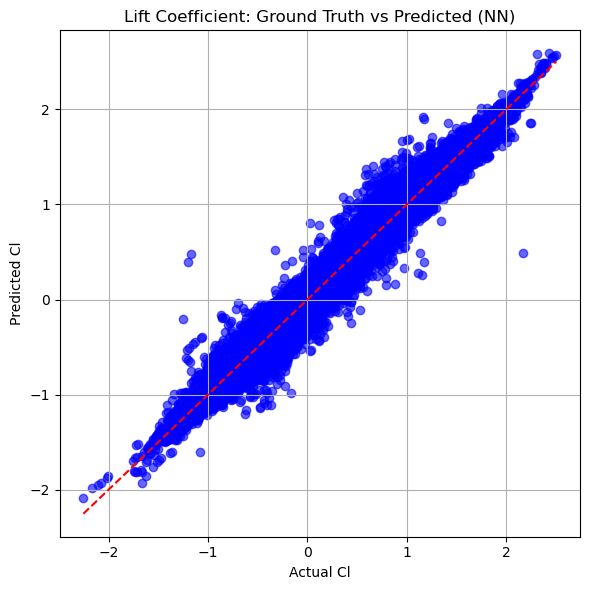

In [29]:
# --- Predict and evaluate ---
preds_scaled = regressor.predict(X_test)
preds = scaler_y.inverse_transform(preds_scaled.reshape(-1, 1))
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))  # <- Fix is here

mse = mean_squared_error(y_test_actual, preds)
print(f"Mean Squared Error (MLP Regressor): {mse:.5f}")

# --- Saving ----

joblib.dump(scaler_X, 'scaler_X.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')

# --- Plot predictions ---
plt.figure(figsize=(6, 6))
plt.scatter(y_test_actual, preds, color='blue', alpha=0.6)
plt.plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()], 'r--')
plt.xlabel("Actual Cl")
plt.ylabel("Predicted Cl")
plt.title("Lift Coefficient: Ground Truth vs Predicted (NN)")
plt.grid(True)
plt.tight_layout()
plt.show()
